In [71]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn as nn
import librosa
import librosa.display
from torch.utils.data import sampler
import torch.optim as optim
import json
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from torchinfo import summary
import spectrum as sp
import scipy.signal as signal
from datetime import datetime

In [72]:
class DAPSDatasetHelper():
    #initialization 
    def __init__(self):
        self.sample_rate=8000
        fft_len=40
        hop_len=10
        self.dir= "./daps_stft_LUT.json"
        openfile=open(self.dir, "r")
        self.dataset_dict= json.load(openfile)
        indx=2
        self.keys={}
        for key  in self.dataset_dict.keys():
            if(key=="produced"):
                self.keys[1]=key
            else:
                self.keys[indx]=key
                indx+=1

        self.num_files_per_category=len(self.dataset_dict["produced"].keys())

    #get the indexed file and sample rate
    def get_indxd_file(self,indx,isLabel=False):
        if(isLabel):
            category=self.keys[1]
        else:
            #category=self.keys[np.random.randint(2,len(self.keys))]
            #consider one category for now
            category=self.keys[3]
        data=abs(np.load(self.dataset_dict[category][str(indx)]))
        Id= self.dataset_dict[category][str(indx)].split("/")[-1].split('.')[0]
        return (data,Id)

In [73]:
class DAPS(Dataset):
    def __init__(self):
        #super().__init__(self)
        self.daps= DAPSDatasetHelper()

    def __getitem__(self, index):
        data,id=self.daps.get_indxd_file(index)
        label,id=self.daps.get_indxd_file(index,True)
        return (data,label)

    def __len__(self):
        
        #print (self.daps.num_files_per_category)
        return (len(self.daps.keys)-1)*self.daps.num_files_per_category

In [74]:
dataset_train = DAPS()
print(dataset_train.__len__())

132000


In [75]:
dtype = torch.float32 # we will be using float throughout this tutorial
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [76]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

In [77]:
NUM_TRAIN=6000
NUM_VAL=1800
NUM_TEST=1000
print_every = 100
dataset_train = DAPS()
batch_size=4
loader_train = DataLoader(dataset_train, batch_size=batch_size, num_workers=8,
                          sampler=sampler.RandomSampler(range(NUM_TRAIN)))
loader_val= DataLoader(dataset_train, batch_size=batch_size, num_workers=8,
                          sampler=sampler.RandomSampler(range(NUM_TRAIN,NUM_VAL+NUM_TRAIN)))
loader_test = DataLoader(dataset_train, batch_size=batch_size, num_workers=8,
                          sampler=sampler.RandomSampler(range(NUM_VAL+NUM_TRAIN, NUM_VAL+NUM_TRAIN+NUM_TEST)))

helper= DAPSDatasetHelper()


In [78]:
print(dataset_train.daps.keys)

{2: 'iphone_bedroom1', 3: 'iphone_balcony1', 4: 'ipad_confroom1', 5: 'clean', 6: 'iphone_livingroom1', 7: 'ipad_confroom2', 8: 'ipad_livingroom1', 9: 'cleanraw', 1: 'produced', 10: 'ipadflat_office1', 11: 'ipadflat_confroom1', 12: 'ipad_office1', 13: 'ipad_balcony1', 14: 'ipad_bedroom1', 15: 'sample', 16: 'ipad_office2'}


In [79]:
#Create Model classes
# create a class for linear layers 
class DenseLayer(nn.Module):
    def __init__(self,input_size,output_size,dropOut_p):
        super().__init__()
        self.dense=nn.Linear(input_size,output_size,bias=True)
        self.activation=nn.Tanh()
        self.dropOut=nn.Dropout(p=dropOut_p,inplace=False)
    
    def forward(self,x):
        y=self.dense(x)
        y=self.activation(y)
        y=self.dropOut(y)
        return y

#class for convolutional layers
class ConvLayer(nn.Module):
    def __init__(self,in_ch,out_ch,kernel_size,stride,padding,dropOut_p):
        super().__init__()
        self.conv=nn.Conv2d(in_ch,out_ch,kernel_size, stride=stride,padding=padding)
        self.activation=nn.ReLU()
        self.dropOut=nn.Dropout2d(p=dropOut_p,inplace=False)
    
    def forward(self,x):
        y=self.conv(x)
        y=self.activation(y)
        y=self.dropOut(y)

        return y

#RNN model for Residual echo suppression
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, fclayer_dim, output_dim, num_layers,dropout_prob):
        super().__init__()
        # Defining the number of layers and the nodes in each layer
        self.layer_dim=num_layers
        self.hidden_dim=hidden_dim
        self.rnn = nn.LSTM(
            fclayer_dim, hidden_dim, num_layers, batch_first=True
        )
        self.tanh=nn.Tanh()
        self.fc1= nn.Linear(input_dim,fclayer_dim)
        self.fc2= nn.Linear(hidden_dim,output_dim)
        self.sig=nn.Sigmoid()
        self.relu= nn.ReLU()


    def forward(self, x):
        
        y= self.fc1(x)

        y= self.tanh(y)
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, y.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(y)

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        #out = out[:, -1, :]
        out=self.tanh(out)
        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc2(out)
        out = self.sig(out)
        return out

In [80]:
#SNR loss where yhat is average power spectrum of de-nonlinearised/denoised signal/ clean signal power 
def Loss_MSE(yhat,y,lossfn):
    target = torch.ones(1).to(device=device)
    #yhat=yhat.squeeze(0)
    #y=y.squeeze(0)
    #loss=lossfn(yhat,y,target)
    loss=lossfn(yhat,y)
    return loss

In [81]:
def check_accuracy(loader, model,lossfn):
    print('Checking accuracy on validation set')
    model.eval()  # set model to evaluation mode
    mse=0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            x=torch.permute(x, (0, 2, 1))
            y=torch.permute(y, (0, 2, 1))
            pw_x=x*x

            # Forward pass: compute scores and loss
            mask = model(pw_x)

            yhat= mask*x
            #yhat=yhat[:,:,:,-1]
            #y=y[:,:,:,-1]
            mse+= Loss_MSE(y,yhat,lossfn)
        mse = mse / len(loader)
        print("Validation loss is", mse.cpu().numpy())
        return  mse.cpu().numpy()

In [82]:
print_every=1500
save_every=1500
lossfn=nn.SmoothL1Loss()
def train_model(model, optimizer, scheduler ,epochs=1):
    """
    Train a model on DAPS.
    
    Inputs:
    - model_fn: A Python function that performs the forward pass of the model.
      It should have the signature scores = model_fn(x, params) where x is a
      PyTorch Tensor of image data, params is a list of PyTorch Tensors giving
      model weights, and scores is a PyTorch Tensor of shape (N, C) giving
      scores for the elements in x.
    - params: List of PyTorch Tensors giving weights for the model
    - learning_rate: Python scalar giving the learning rate to use for SGD
    
    Returns: val loss and train loss
    """
    val_loss=[]
    train_loss=[]
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        running_loss = 0
        for t, (x, y) in enumerate(loader_train):
            
            #print(y.shape)          
            #iterate over each stft frame 
            x=x.to(device=device, dtype=dtype)
            y=y.to(device=device, dtype=dtype)
            
            x=torch.permute(x, (0, 2, 1))
            y=torch.permute(y, (0, 2, 1))
            
            pw_x=x*x

            # Forward pass: compute scores and loss
            mask = model(pw_x)

            #print(mask.shape)

            yhat= mask*x

            #yhat=yhat[:,:,:,-1]
            #y=y[:,:,:,-1]

            loss = Loss_MSE(yhat, y, lossfn)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            # Update parameters. We don't want to backpropagate through the
            running_loss += loss.item()
            

            if (t+1) % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.8f' % (e, t+1, (running_loss/len(loader_train))))
                train_loss.append(running_loss/len(loader_train))
                #check_accuracy_part2(loader_val, model_fn, params)
            if (t+1) % save_every == 0:
                torch.save(model.state_dict(),model_path) 
            
        vloss=check_accuracy(loader_val,model,lossfn)
        model.train()
        val_loss.append(vloss)
        scheduler.step(loss)
    return (train_loss,val_loss)

In [83]:
learning_rate = 1e-3
nfft_len=511
hop_size=nfft_len//4
specdims=(256,64)
model = LSTMNet(input_dim=256, hidden_dim=25, fclayer_dim=25, output_dim=256, num_layers=1,dropout_prob=0.0)
# you can use Nesterov momentum in optim.SGD
#optimizer = optim.SGD(model.parameters(), lr=learning_rate,
#                     momentum=0.9, nesterov=True)
# you can use Nesterov momentum in optim.SGD
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [84]:
batch_size = batch_size
cfg=summary(model, input_size=(batch_size,64, 256))
print(cfg)
epochs=200

Layer (type:depth-idx)                   Output Shape              Param #
LSTMNet                                  --                        --
├─Linear: 1-1                            [4, 64, 25]               6,425
├─Tanh: 1-2                              [4, 64, 25]               --
├─LSTM: 1-3                              [4, 64, 25]               5,200
├─Linear: 1-4                            --                        (recursive)
├─Tanh: 1-5                              [4, 64, 25]               --
├─ReLU: 1-6                              --                        --
├─Linear: 1-7                            [4, 64, 256]              6,656
├─Sigmoid: 1-8                           [4, 64, 256]              --
Total params: 18,281
Trainable params: 18,281
Non-trainable params: 0
Total mult-adds (M): 1.38
Input size (MB): 0.26
Forward/backward pass size (MB): 0.63
Params size (MB): 0.07
Estimated Total Size (MB): 0.96


In [65]:
now = datetime.now()
timestamp= now.strftime("%d%m%H%M%S")
filename='./pretrained/info/cfg'+timestamp+'.txt'
model_path="./pretrained/model/res_lstm_"+timestamp+".pth"
dict_params={}
dict_params["model_summary"]=cfg
dict_params["optimizer"]=optimizer
dict_params["epochs"]=epochs
dict_params["loss_function"]=lossfn
with open(filename, 'w') as f:
    f.write(str(dict_params))
(train_loss,val_loss)=train_model(model, optimizer, scheduler,epochs)

Epoch 0, Iteration 1500, loss = 0.21699364
Checking accuracy on validation set
Validation loss is 0.17708348
Epoch 1, Iteration 1500, loss = 0.20083019
Checking accuracy on validation set
Validation loss is 0.17112921
Epoch 2, Iteration 1500, loss = 0.19766182
Checking accuracy on validation set
Validation loss is 0.16878861
Epoch 3, Iteration 1500, loss = 0.19584756
Checking accuracy on validation set
Validation loss is 0.16674292
Epoch 4, Iteration 1500, loss = 0.19472077
Checking accuracy on validation set
Validation loss is 0.16547063
Epoch 5, Iteration 1500, loss = 0.19372938
Checking accuracy on validation set
Validation loss is 0.16421911
Epoch 6, Iteration 1500, loss = 0.19321102
Checking accuracy on validation set
Validation loss is 0.16466911
Epoch 7, Iteration 1500, loss = 0.19261304
Checking accuracy on validation set
Validation loss is 0.1634253
Epoch 8, Iteration 1500, loss = 0.19228171
Checking accuracy on validation set
Validation loss is 0.16304082
Epoch 9, Iteration 1

In [16]:
model=LSTMNet(input_dim=256, hidden_dim=25, fclayer_dim=25, output_dim=256, num_layers=1,dropout_prob=0.0)
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [85]:
dataset=DAPSDatasetHelper()
test_index=2423
model.to(device="cpu")
img_test,_= dataset.get_indxd_file(test_index)
img_label,_= dataset.get_indxd_file(test_index,True)
img = torch.tensor(img_test)
img= torch.permute(img,(1,0))
img=img.unsqueeze(0)
img=img.to(dtype=torch.float32)
model.eval()
with torch.no_grad():
    out=model(img*img)
out = out *img
out=out.squeeze(0)
out= torch.permute(out,(1,0))

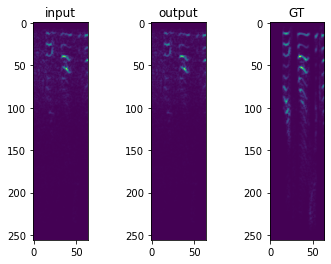

In [86]:
plt.figure()
ax1=plt.subplot(1,3,1)
ax1.imshow(img_test)
ax1.title.set_text("input")
ax2=plt.subplot(1,3,2)
ax2.imshow(out.cpu().numpy())
ax2.title.set_text("output")
ax3=plt.subplot(1,3,3)
ax3.imshow(img_label)
ax3.title.set_text("GT")

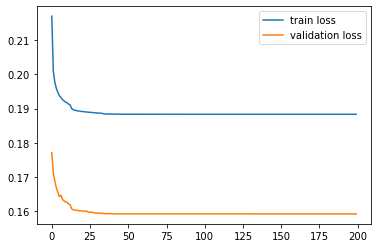

In [87]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(["train loss","validation loss"])

Buffer level processing with 10ms of input samples being buffered and fed to the feature extractor in every iteration

894.5214
(256, 1890)


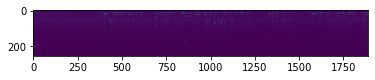

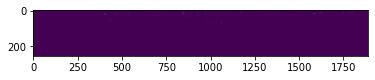

In [88]:
dirpath_daps="../dataset_daps/daps/"
input,sr=librosa.load(dirpath_daps+'/ipad_balcony1/f1_script1_ipad_balcony1.wav',duration=30,sr=8000)
stftx=librosa.stft(input,n_fft=nfft_len,hop_length=nfft_len//4)
magstftx,phasex=librosa.magphase(stftx)
segments=stftx.shape[1]//specdims[1]
specs=np.zeros_like(magstftx)
outs=[]
for i in range(0,segments):
    spec=magstftx[:,specdims[1]*i:specdims[1]*i+specdims[1]]
    img = torch.tensor(spec)
    img= torch.permute(img,(1,0))
    img=img.unsqueeze(0)
    img=img.to(dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        out=model(img*img)
    out=out.squeeze(0)
    out= torch.permute(out,(1,0))
    out=out.numpy()*spec
    outs.append(out)
    specs[:,specdims[1]*i:specdims[1]*i+specdims[1]]=out*spec

specs=np.array(specs)
print(np.max(specs))

reconst=specs*phasex

plt.figure()
plt.imshow(magstftx)

plt.figure()
plt.imshow(specs)

print(stftx.shape)

istftx=librosa.istft(stftx,hop_length=nfft_len//4,n_fft=nfft_len)
reistftx=librosa.istft(reconst,hop_length=nfft_len//4,n_fft=nfft_len)

In [89]:
wav.write("./input.wav", 8000, input)
wav.write("./reconstructed.wav", 8000, reistftx)

In [90]:
class AdaptiveFilters():
    def __init__(self,mu,taps):
        self.e=0
        self.w=np.zeros((taps,1))
        self.xd=np.zeros((taps,1))
        self.mu=mu
        self.N=taps

In [91]:
class NLMS(AdaptiveFilters):
    #initialize
    def __init__(self,mu,taps):
        super().__init__(mu,taps)
        self.mu=mu
        self.N=taps
        self.e=0
        self.w=np.zeros((taps,1))
        self.xd=np.zeros((taps,1))

    #updates the filter sample by sample and updates weights sample by sample
    def run(self,x,d):
        N=self.N
        #udpate delay line 
        self.xd[0]=x
        #compute filter output
        y = np.dot(self.w.T,self.xd)
        #compute input energy
        pw=np.linalg.norm(self.xd)
        pw=pw*pw
        #pw=pw*pw
        #calculate error
        e = d - y
        self.e=e

        #normalize by input energy
        e= e/(pw+0.0000000001)
        #compute gradients
        Fw=self.mu*np.multiply(self.xd,e)
        
        Fw=Fw.reshape(Fw.shape[0],-1)
        #weight update
        self.w = self.w + Fw
    
        #filtered output post update
        y = np.dot(self.w.T,self.xd)
        #shift delay line
        self.xd[1:]=self.xd[:-1]
 
        #return current output sample, current error sample and current weights
        return (y,self.e,self.w)

In [115]:
d,sr= librosa.load('../dataset/AEC-Challenge/datasets/synthetic/nearend_mic_signal/nearend_mic_fileid_12.wav',sr=8000)
x,sr=librosa.load('../dataset/AEC-Challenge/datasets/synthetic/farend_speech/farend_speech_fileid_12.wav',sr=8000)
echo,sr=librosa.load('../dataset/AEC-Challenge/datasets/synthetic/echo_signal/echo_fileid_12.wav',sr=8000)
near_end,sr= librosa.load('../dataset/AEC-Challenge/datasets/synthetic/nearend_speech/nearend_speech_fileid_12.wav',sr=8000)

In [116]:
d=np.concatenate((d,d),axis=0)
x=np.concatenate((x,x),axis=0)
near_end=np.concatenate((near_end,near_end),axis=0)
echo=np.concatenate((echo,echo),axis=0)
echo=librosa.util.normalize(echo)
near_end=librosa.util.normalize(near_end)

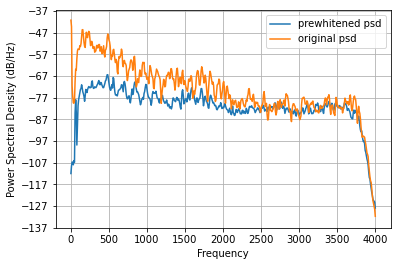

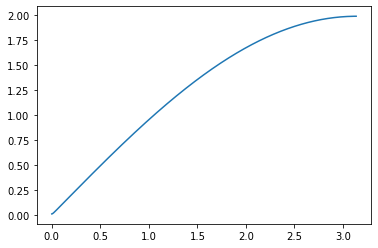

In [123]:
#x=librosa.util.normalize(x)
a,_,_=sp.aryule(x,order=20)
pwhite_x=signal.lfilter(a,[1],x)
lpf=[1,-0.99]
pwhite_x=signal.lfilter(lpf,[1],x)
plt.figure()
plt.psd(pwhite_x,NFFT=1024,Fs=8000,noverlap=256)
plt.psd(d,NFFT=1024,Fs=8000,noverlap=256)
plt.legend(["prewhitened psd", "original psd"])
plt.show()

plt.figure()

w,h=signal.freqz(b=lpf, a=1, worN=None, whole=0, plot=None)
ax=plt.plot(w,np.abs(h))

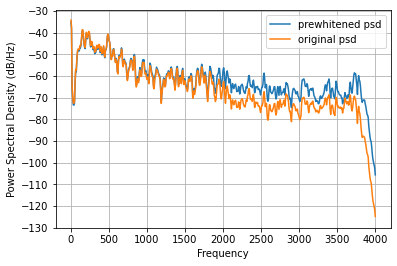

In [83]:
d=librosa.util.normalize(d)
ad,_,_=sp.aryule(d,order=20)
pwhite_d=signal.lfilter(ad,[1],d)
lpf=[1,0.99]
#pwhite_d=signal.lfilter([1],lpf,pwhite_d)
plt.figure()
plt.psd(pwhite_d,NFFT=1024,Fs=8000,noverlap=256)
plt.psd(d,NFFT=1024,Fs=8000,noverlap=256)
plt.legend(["prewhitened psd", "original psd"])
plt.show()

In [84]:
# def prewhiten(dataset):
#   mean= np.mean(dataset, axis=0)
#   dataset = dataset - mean
#   map_dataset = dataset /np.sqrt(np.cov(dataset))
#   return map_dataset
# pwhite_d1=prewhiten(d)
# #pwhite_d=signal.lfilter(a,[1],d)
# lpf=[1,0.8]
# #pwhite_d=signal.lfilter([1],lpf,pwhite_d)
# plt.figure()
# plt.psd(pwhite_d,NFFT=1024,Fs=8000,noverlap=256)
# plt.psd(d,NFFT=1024,Fs=8000,noverlap=256)
# plt.legend(["prewhitened psd", "original psd"])
# plt.show()

In [85]:
input=pwhite_d
stftx=librosa.stft(input,n_fft=nfft_len,hop_length=nfft_len//4)
magstftx,phasex=librosa.magphase(stftx)
segments=stftx.shape[1]//specdims[1]
specs=np.zeros_like(magstftx)
outs=[]
for i in range(0,segments+1):
    spec=magstftx[:,specdims[1]*i:specdims[1]*i+specdims[1]]
    img = torch.tensor(spec)
    img= torch.permute(img,(1,0))
    img=img.unsqueeze(0)
    img=img.to(dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        out=model(img*img)
    out=out.squeeze(0)  
    out= torch.permute(out,(1,0))
    out=out.numpy()*spec
    outs.append(out)
    specs[:,specdims[1]*i:specdims[1]*i+specdims[1]]=out*spec

specs=np.array(specs)/np.max(specs)

reconst=specs*phasex

# plt.figure()
# plt.imshow(magstftx)

# plt.figure()
# plt.imshow(specs)

# print(stftx.shape)

istftx=librosa.istft(stftx,hop_length=nfft_len//4,n_fft=nfft_len)
reistftx=librosa.istft(reconst,hop_length=nfft_len//4,n_fft=nfft_len)
prefilt_desired=librosa.util.normalize(reistftx)

In [86]:
input=pwhite_x
stftx=librosa.stft(input,n_fft=nfft_len,hop_length=nfft_len//4)
magstftx,phasex=librosa.magphase(stftx)
segments=stftx.shape[1]//specdims[1]
specs=np.zeros_like(magstftx)
outs=[]
for i in range(0,segments+1):
    spec=magstftx[:,specdims[1]*i:specdims[1]*i+specdims[1]]
    img = torch.tensor(spec)
    img= torch.permute(img,(1,0))
    img=img.unsqueeze(0)
    img=img.to(dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        out=model(img*img)
    out=out.squeeze(0)  
    out= torch.permute(out,(1,0))
    out=out.numpy()*spec
    outs.append(out)
    specs[:,specdims[1]*i:specdims[1]*i+specdims[1]]=out*spec

specs=np.array(specs)/np.max(specs)

reconst=specs*phasex

istftx=librosa.istft(stftx,hop_length=nfft_len//4,n_fft=nfft_len)
reistftx=librosa.istft(reconst,hop_length=nfft_len//4,n_fft=nfft_len)
prefilt_ip=librosa.util.normalize(reistftx)

In [87]:
#test wrapper for NLMS filter on aec data for single talk case
taps=1024
lmscls= NLMS(0.1,taps)
w=np.zeros((taps,1))
y=np.zeros_like(x)
e=np.zeros_like(x)
#x1=librosa.util.normalize(x)
#d1=librosa.util.normalize(echo)
for i in range(0,len(x)):
    (y[i],e[i],w2)=lmscls.run(pwhite_x[i],pwhite_d[i])
y=signal.lfilter(w2[:,0],[1],x)
e=d-y

In [102]:
#test wrapper for NLMS filter on aec data for single talk case
taps=1024
lmscls= NLMS(0.5,taps)
w1=np.zeros((taps,1))
y1=np.zeros_like(x)
e1=np.zeros_like(x)
for i in range(0,len(prefilt_ip)):
    (y1[i],e1[i],w3)=lmscls.run(prefilt_ip[i],prefilt_desired[i])
y1=signal.lfilter(w3[:,0],[1],x)
e1=d-y1

Text(0.5, 1.0, 'far end reference(input signal)')

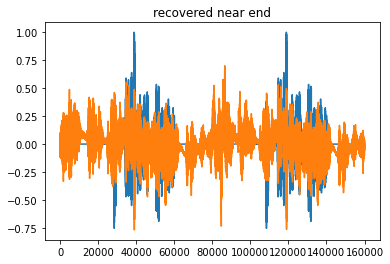

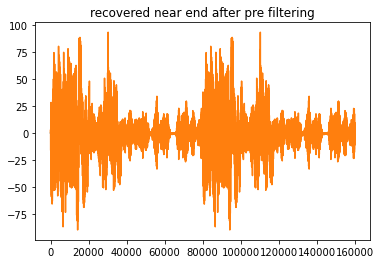

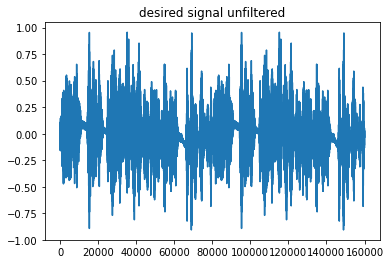

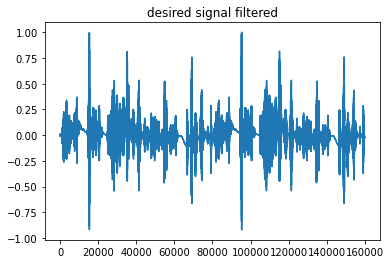

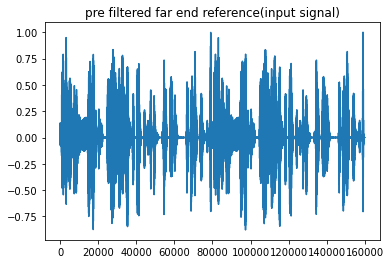

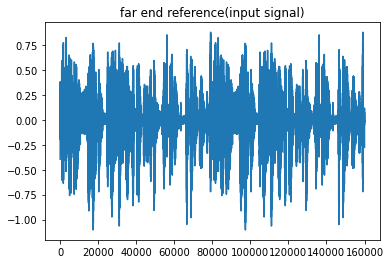

In [103]:
plt.figure()
plt.plot(near_end)
plt.plot(e)
plt.title("recovered near end")
plt.figure()
plt.plot(near_end)
plt.plot(e1)
plt.title("recovered near end after pre filtering")
plt.figure()
plt.plot(pwhite_d)
plt.title("desired signal unfiltered")
plt.figure()
plt.plot(prefilt_desired)
plt.title("desired signal filtered")
plt.figure()
plt.plot(prefilt_ip)
plt.title("pre filtered far end reference(input signal)")
plt.figure()
plt.plot(pwhite_x)
plt.title("far end reference(input signal)")


In [104]:
wav.write("./nlms_er.wav", 8000, e)
wav.write("./nlms_wprefilter.wav", 8000, e1)

In [169]:
wav.write("./nlms_estimated_echo.wav", 8000, y)
wav.write("./nlms_wprefilter_estimated_echo.wav", 8000, y1)